In [45]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch import nn
from torch import autograd
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from tqdm import tqdm
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.autograd import Variable

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from torch.nn.utils import weight_norm as wn
from torch.nn.utils import remove_weight_norm as wnr

In [13]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index.long(), num_nodes=x.size(0))
        x = self.lin(x)
        return self.propagate(edge_index, x=x)

    def message(self, x_j, edge_index):
        row, col = edge_index
        deg = degree(row, 2708, dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
#         x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [16]:
epsilon_graph = 0.01
xi = 1e-05 # small constant for finite difference
epsilon = 1.0
alpha = 0.5
beta = 1.0
weight_decay = 5e-4

In [36]:
def my_kld_with_logit(neighbor, self_logit):
    q = nn.Softmax(dim=1)(neighbor)
    q = torch.argmax(q, dim=1)
    cross_entropy = F.cross_entropy(self_logit, q)
    entropy = F.cross_entropy(neighbor, q)
    return torch.mean(cross_entropy - entropy)
def my_neighbor_kld_with_logit(neighbor1, neighbor2, self_logit): # call each hop
    dist = 0
    dist += my_kld_with_logit(neighbor1, self_logit)
    dist += my_kld_with_logit(neighbor2, self_logit)
    return dist
def generate_gat_p(x, neighbor1, neighbor2, self_logit):
    dist = my_neighbor_kld_with_logit(neighbor1, neighbor2, self_logit) # KL loss
    grad = torch.autograd.grad(dist, x, retain_graph=True, allow_unused=True)[0]
    d = grad #stop gradients
    return epsilon_graph * F.normalize(d, dim=1, p=2)
def generate_gat_loss(x, neighbor1, neighbor2, self_logit):
    r_gadv = generate_gat_p(x, neighbor1, neighbor2, self_logit)
    logit_m = model((x + r_gadv).to(device), dataset[0].edge_index.to(device)) # x+r 的 embedding
    gat_loss = my_neighbor_kld_with_logit(neighbor1, neighbor2, logit_m)
    return gat_loss, logit_m # 應該可以不用加identity

def generate_vat_p(x, self_logit):
    d = Variable(torch.randn(size=x.shape), requires_grad=True)
    for _ in range(1): # num_power_iterations
        d = xi * F.normalize(d, dim=1, p=2)
        logit_p = self_logit
        d = d.to(device)
        x = x.to(device)
        logit_m = model((x + d).to(device), dataset[0].edge_index.to(device))
        # 省略 mask_vat, 因其沒有True過
        dist = my_kld_with_logit(logit_p, logit_m)
        grad = torch.autograd.grad(dist, d, retain_graph=True, allow_unused=True)[0]
        d = grad
    return epsilon * F.normalize(d, dim=1, p=2)
def generate_vat_loss(x, self_logit):
    r_vadv = generate_vat_p(x, self_logit)
    r_vadv = r_vadv.to(device)
    x = x.to(device)
    logit_p = self_logit
    logit_m = model((x + r_vadv).to(device), dataset[0].edge_index.to(device))
    vat_loss = my_kld_with_logit(logit_p, logit_m)
    return vat_loss

In [18]:
def generate_logits(self_logit, e=dataset[0].edge_index):# 1-hop neighborhood
    neighbor_ids = torch.empty(dataset[0].num_nodes,2)
    # 1-hop neighborhood
    for idx in range(dataset[0].num_nodes):
        num_neighbors = 2 
        neighbors = e[1][torch.where(e[0]==idx)[0]]
        for i in range(num_neighbors):
            neighbor_ids[idx][i] = neighbors[random.randint(0,len(neighbors)-1)]
        neighbor_ids = neighbor_ids.int()
    neighbor_ids_1 = neighbor_ids[:,0]
    neighbor_ids_2 = neighbor_ids[:,1]
    output = self_logit # model(x.to(device), e.to(device))
    neighbor_1 = output[neighbor_ids_1.long(),:] # n1-1's embedding
    neighbor_2 = output[neighbor_ids_2.long(),:] # n1-2's embedding
    neighbor_12 = torch.cat([neighbor_1, neighbor_2],1)
    return neighbor_1, neighbor_2

In [19]:
# easy way to tet model
model = Net().to(device)
X = Variable(dataset[0].x, requires_grad=True)
logits = model(X.to(device), dataset[0].edge_index.to(device))

n1, n2 = generate_logits(logits, dataset[0].edge_index)
gat_loss, logit_m = generate_gat_loss(X, n1, n2, logits)
vat_loss = generate_vat_loss(X, logits)
gat_loss, vat_loss

(tensor(0.1499, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1251, device='cuda:0', grad_fn=<MeanBackward0>))

In [20]:
# dataset[0].x[dataset[0].val_mask].shape

In [21]:
# get only training edges
def get_edges(N, data):
    e1, e2 = list(), list()
    for i in range(data.edge_index.shape[1]):
        if data.edge_index[0][i] < 140 and data.edge_index[1][i] < 140:
            e1.append(data.edge_index[0][i].item())
            e2.append(data.edge_index[1][i].item())
    edges = np.concatenate((np.array(e1).reshape(1,-1), np.array(e2).reshape(1,-1)))
    edges = torch.IntTensor(edges) # restore the dtype of dataset[0].edge_index
    return edges

In [52]:
model = Net().to(device)

def train(data=dataset[0]):    
#     data = dataset[0].to(device)
    data = data.to(device) # added
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)# 0.01 5e-4
    
    X = Variable(data.x, requires_grad=True)
    N = X.shape[0]
    
    model.train()
    
    train_loss_record = list()
    train_acc_record = list()
    
    val_loss_record = list()
    val_acc_record = list()
    
    test_loss_record = list()
    test_acc_record = list()
    
    
    for epoch in range(200):
        optimizer.zero_grad()
        
        logits = model(X.to(device), dataset[0].edge_index.to(device)) # masked ce loss!!!!
        
        n1, n2 = generate_logits(logits, dataset[0].edge_index)
        
        l2_norm = 0.0
        for p in model.parameters():
            l2_norm += torch.norm(p, 2)
        
        sup_loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask]) # cross-entropy loss
        gat_loss, logit_m = generate_gat_loss(X, n1, n2, logits) # mask???
        vat_loss = generate_vat_loss(X, logits) # mask???
         
        loss = sup_loss + beta * gat_loss + alpha * vat_loss + weight_decay * l2_norm # objective function
        train_loss_record.append(sup_loss)
        
        _, pred = model(data.x.to(device), data.edge_index.to(device)).max(dim=1)
        
        train_correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
        train_acc = train_correct / int(data.train_mask.sum())
        train_acc_record.append(train_acc)
        
        val_sup_loss = F.nll_loss(logits[data.val_mask], data.y[data.val_mask])
        val_loss_record.append(val_sup_loss)
        val_correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
        val_acc = val_correct / int(data.val_mask.sum())
        val_acc_record.append(val_acc)
        
        test_sup_loss = F.nll_loss(logits[data.test_mask], data.y[data.test_mask])
        test_loss_record.append(test_sup_loss)
        test_correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        test_acc = test_correct / int(data.test_mask.sum())
        test_acc_record.append(test_acc)
        
        print(
            "Epoch:", '%04d' % (epoch + 1),
#             "tr_obj=", "{:.4f}".format(loss),
            "tr_acc=", "{:.4f}".format(train_acc),
            "tr_loss=", "{:.4f}".format(sup_loss),
#             "tr_l2=", "{:.4f}".format(l2_norm),
#             "tr_vat=", "{:.6f}".format(vat_loss),
#             "tr_gat=", "{:.6f}".format(gat_loss)
        )
        loss.backward()
        optimizer.step()
        
        # validation
         # cross-entropy loss
#         val_gat_loss, _ = generate_gat_loss(X.to(device), n1, n2, logits) # mask???
#         val_vat_loss = generate_vat_loss(X.to(device), logits) # mask???
        
#         val_loss = val_sup_loss + val_gat_loss + val_vat_loss # objective function
        
        
        
        print(
            "Epoch:", '%04d' % (epoch + 1),
#             "va_obj=", "{:.4f}".format(val_loss),
            "va_acc=", "{:.4f}".format(val_acc),
            "va_loss=", "{:.4f}".format(val_sup_loss),
#             "va_l2=", "{:.4f}".format(outs[4]),
#             "va_vat=", "{:.6f}".format(val_vat_loss),
#             "va_gat=", "{:.6f}".format(val_gat_loss)
        )

        # testing
#         print('-'*30)
    
    model.eval()
    _, pred = model(data.x.to(device), data.edge_index.to(device)).max(dim=1)
    
    # final: when training finished
    train_correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    train_acc = train_correct / int(data.train_mask.sum())
    
    val_correct = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    val_acc = val_correct / int(data.val_mask.sum())
    
    test_correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    test_acc = test_correct / int(data.test_mask.sum())
    
    print('Train Accuracy: {:.4f}'.format(train_acc))
    print('Val Accuracy: {:.4f}'.format(val_acc))
    print('Test Accuracy: {:.4f}'.format(test_acc))
    
    plt.plot(train_acc_record)
    plt.plot(val_acc_record)
    plt.show()
    
    plt.plot(train_loss_record)
    plt.plot(val_loss_record)
    plt.show()
    
    return 

Epoch: 0001 tr_acc= 0.1571 tr_loss= 1.9418
Epoch: 0001 va_acc= 0.1220 va_loss= 1.9604
Epoch: 0002 tr_acc= 0.2786 tr_loss= 1.9270
Epoch: 0002 va_acc= 0.1880 va_loss= 1.9447
Epoch: 0003 tr_acc= 0.3357 tr_loss= 1.9207
Epoch: 0003 va_acc= 0.2100 va_loss= 1.9409
Epoch: 0004 tr_acc= 0.3857 tr_loss= 1.9235
Epoch: 0004 va_acc= 0.1560 va_loss= 1.9422
Epoch: 0005 tr_acc= 0.2857 tr_loss= 1.9211
Epoch: 0005 va_acc= 0.1040 va_loss= 1.9430
Epoch: 0006 tr_acc= 0.2786 tr_loss= 1.9110
Epoch: 0006 va_acc= 0.1020 va_loss= 1.9426
Epoch: 0007 tr_acc= 0.3071 tr_loss= 1.9052
Epoch: 0007 va_acc= 0.1160 va_loss= 1.9403
Epoch: 0008 tr_acc= 0.4143 tr_loss= 1.9012
Epoch: 0008 va_acc= 0.2060 va_loss= 1.9380
Epoch: 0009 tr_acc= 0.5071 tr_loss= 1.8939
Epoch: 0009 va_acc= 0.2360 va_loss= 1.9361
Epoch: 0010 tr_acc= 0.5286 tr_loss= 1.8866
Epoch: 0010 va_acc= 0.2520 va_loss= 1.9340
Epoch: 0011 tr_acc= 0.5357 tr_loss= 1.8758
Epoch: 0011 va_acc= 0.2600 va_loss= 1.9340
Epoch: 0012 tr_acc= 0.4643 tr_loss= 1.8726
Epoch: 0012

Epoch: 0098 tr_acc= 0.9286 tr_loss= 0.7155
Epoch: 0098 va_acc= 0.5200 va_loss= 1.6503
Epoch: 0099 tr_acc= 0.9286 tr_loss= 0.7106
Epoch: 0099 va_acc= 0.5060 va_loss= 1.6507
Epoch: 0100 tr_acc= 0.9143 tr_loss= 0.7239
Epoch: 0100 va_acc= 0.5300 va_loss= 1.6369
Epoch: 0101 tr_acc= 0.9357 tr_loss= 0.6514
Epoch: 0101 va_acc= 0.5260 va_loss= 1.6259
Epoch: 0102 tr_acc= 0.9571 tr_loss= 0.6673
Epoch: 0102 va_acc= 0.5460 va_loss= 1.6211
Epoch: 0103 tr_acc= 0.9143 tr_loss= 0.7175
Epoch: 0103 va_acc= 0.5460 va_loss= 1.6329
Epoch: 0104 tr_acc= 0.9357 tr_loss= 0.7165
Epoch: 0104 va_acc= 0.5340 va_loss= 1.6320
Epoch: 0105 tr_acc= 0.9571 tr_loss= 0.7232
Epoch: 0105 va_acc= 0.5420 va_loss= 1.6317
Epoch: 0106 tr_acc= 0.9714 tr_loss= 0.6946
Epoch: 0106 va_acc= 0.5440 va_loss= 1.6252
Epoch: 0107 tr_acc= 0.9429 tr_loss= 0.6915
Epoch: 0107 va_acc= 0.5180 va_loss= 1.6254
Epoch: 0108 tr_acc= 0.9643 tr_loss= 0.6428
Epoch: 0108 va_acc= 0.5300 va_loss= 1.6180
Epoch: 0109 tr_acc= 0.9643 tr_loss= 0.6495
Epoch: 0109

Epoch: 0194 tr_acc= 0.9643 tr_loss= 0.5583
Epoch: 0194 va_acc= 0.5500 va_loss= 1.6110
Epoch: 0195 tr_acc= 0.9357 tr_loss= 0.5656
Epoch: 0195 va_acc= 0.5260 va_loss= 1.6262
Epoch: 0196 tr_acc= 0.9571 tr_loss= 0.5235
Epoch: 0196 va_acc= 0.5660 va_loss= 1.6244
Epoch: 0197 tr_acc= 0.9571 tr_loss= 0.5036
Epoch: 0197 va_acc= 0.5160 va_loss= 1.6150
Epoch: 0198 tr_acc= 0.9714 tr_loss= 0.5434
Epoch: 0198 va_acc= 0.5280 va_loss= 1.6422
Epoch: 0199 tr_acc= 0.9714 tr_loss= 0.5382
Epoch: 0199 va_acc= 0.5420 va_loss= 1.6166
Epoch: 0200 tr_acc= 0.9714 tr_loss= 0.5388
Epoch: 0200 va_acc= 0.5560 va_loss= 1.6191
Train Accuracy: 0.9929
Val Accuracy: 0.4860
Test Accuracy: 0.5120


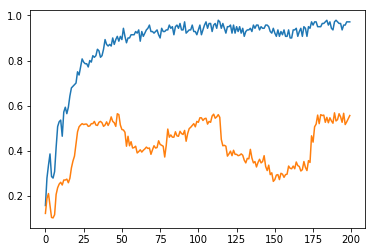

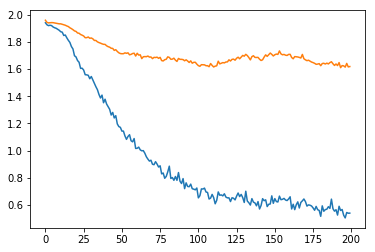

In [53]:
train()

In [ ]:
model = Net().to(device)
X = Variable(dataset[0].x, requires_grad=True) 
data = data.to(device) # added
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()

optimizer.zero_grad()

logits = model(X.to(device), data.edge_index.to(device)) # self_logit

n1, n2 = generate_logits(logits, dataset[0].edge_index)

sup_loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask]) # cross-entropy loss
# gat_loss, logit_m = generate_gat_loss(X[data.train_mask], n1[data.train_mask], n2[data.train_mask], logits[data.train_mask])
vat_loss = generate_vat_loss(X[data.train_mask], logits[data.train_mask])

# loss = sup_loss + gat_loss + vat_loss # objective function
# print(epoch, "/200: ", sup_loss, gat_loss, vat_loss, loss)
# loss.backward()
# optimizer.step()

In [ ]:
X[data.train_mask]

In [ ]:
dist = my_neighbor_kld_with_logit(n1[data.train_mask], n2[data.train_mask], logits[data.train_mask]) # KL loss
print(dist)
grad = torch.autograd.grad(dist, X[data.train_mask], retain_graph=True, allow_unused=True)[0]
print(grad)
# d = grad #stop gradients
epsilon_graph * F.normalize(d, dim=1, p=2)